In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [179]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.adv_model import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNN, DKNNL2
from lib.utils import *
from lib.lip_model import *
from lib.knn import *
from lib.dknn_attack_l2 import DKNNL2Attack

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [33]:
def r_separate(x, y, r=10):
    
    x = x.view(x.size(0), -1)
    edge = torch.zeros((x.size(0), x.size(0)), dtype=torch.uint8)
    
    for i in range(x.size(0)):
        if i % 100 == 0:
            print(i)
        dist = (x[i].unsqueeze(0) - x).norm(2, 1)
        dist_ind = dist < r
        diff_ind = y[i] != y
        edge[i, dist_ind & diff_ind] = 1
    
    return edge

In [95]:
def r_separate(x, y, r=1):
    
#     full_range = np.arange(x.size(0))
    x = x.view(x.size(0), -1)
    mask = torch.ones(x.size(0), dtype=torch.uint8)
    start = time.time()
    
    for i in range(x.size(0)):
        if i % 100 == 0:
            print(time.time() - start)
            start = time.time()
        if mask[i] == 0:
            continue
            
        dist = (x[i].unsqueeze(0) - x[mask]).norm(2, 1)
        dist_ind = (dist < r).numpy()
        diff_ind = (y[i] != y[mask]).numpy()
        ind = np.where(dist_ind & diff_ind)[0]
        
        if len(ind) > 0:
            mask[mask][ind[0]] = 0
            mask[i] = 0
    
    return mask

def r_separate_fast(x, y, r=1):
    
#     ind = np.arange(x.size(0))
    x = x.view(x.size(0), -1)
    mask = torch.ones(x.size(0), dtype=torch.uint8)
    start = time.time()
    
    for i in range(x.size(0) - 1, -1, -1):
        if i % 100 == 0:
            print(time.time() - start)
            start = time.time()
        if mask[i] == 0:
            continue
        dist = (x[i].unsqueeze(0) - x[mask][:i]).norm(2, 1)
        dist_ind = (dist < r).numpy()
        diff_ind = (y[i] != y[mask][:i]).numpy()
        ind = np.where(dist_ind & diff_ind)[0]
        if len(ind) > 0:
            mask[mask][:i][ind[0]] = 0
            mask[i] = 0
    
    return mask

In [158]:
with torch.no_grad():
    edge = r_separate(rep_train[:2000].cpu(), y_train[:2000], r=5)

8.58306884765625e-06
2.2972819805145264
2.1110424995422363
2.305581569671631
2.618946075439453
2.3540453910827637
2.2347640991210938
2.266505002975464
2.3151679039001465
2.156545639038086
1.9811303615570068
1.9504258632659912
2.013305902481079
1.9094479084014893
1.8231568336486816
2.1141209602355957
2.064314365386963
2.0291969776153564
2.1817259788513184
1.947507381439209


In [159]:
with torch.no_grad():
    edge2 = r_separate_fast(rep_train[:2000].cpu(), y_train[:2000], r=5)

1.8797531127929688
1.9197137355804443
2.038306474685669
1.8453080654144287
1.3624498844146729
1.9046738147735596
1.67976975440979
1.8577404022216797
1.2187299728393555
1.9455478191375732
1.6496398448944092
1.2031362056732178
0.9679687023162842
1.080486536026001
1.1456124782562256
1.0779838562011719
1.0561070442199707
1.0811254978179932
0.5763309001922607
0.8448095321655273


In [166]:
for i in range(2000):
    if edge[i] == 0:
        continue
    dist = (rep_train[i].unsqueeze(0) - rep_train[:2000]).view(2000, -1).norm(2, 1)[edge].cpu().numpy()
    if np.sum((dist < 5) & (y_train[i] != y_train[:2000][edge]).numpy()) > 0:
        print('yikes')

In [167]:
for i in range(2000):
    if edge2[i] == 0:
        continue
    dist = (rep_train[i].unsqueeze(0) - rep_train[:2000]).view(2000, -1).norm(2, 1)[edge2].cpu().numpy()
    if np.sum((dist < 5) & (y_train[i] != y_train[:2000][edge2]).numpy()) > 0:
        print('yikes')

In [168]:
edge.sum()

tensor(1922)

In [169]:
edge2.sum()

tensor(1930)

In [6]:
exp_id = 2

# model_name = 'train_mnist_exp%d.h5' % exp_id
# net = BasicModel()

# model_name = 'train_mnist_snnl_exp%d.h5' % exp_id
# net = SNNLModel(train_it=True)

# model_name = 'train_mnist_hidden_mixup_exp%d.h5' % exp_id
# net = HiddenMixupModel()

# model_name = 'train_mnist_vae_exp%d.h5' % exp_id
# # net = VAE((1, 28, 28), num_classes=10, latent_dim=20)
# net = VAE2((1, 28, 28), num_classes=10, latent_dim=1000)

# model_name = 'train_mnist_cav_exp%d.h5' % exp_id
# net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)

# model_name = 'lip_mnist_exp%d.h5' % exp_id
# net = LipschitzModel()

# model_name = 'dist_mnist_exp%d.h5' % exp_id
# init_it = 1
# train_it = False
# net = NeighborModel(num_classes=10, init_it=init_it, train_it=train_it)

model_name = 'adv_mnist_exp%d.h5' % exp_id
basic_net = BasicModel()
# basic_net = BasicModelV2()
config = {'epsilon': 0.3,
          'num_steps': 40,
          'step_size': 0.01,
          'random_start': True,
          'loss_func': 'xent'}
net = PGDL2Model(basic_net, config)

# model_name = 'lipae_mnist_exp%d.h5' % exp_id
# init_it = 1
# train_it = False
# latent_dim = 128
# alpha = 1e2
# net = NCA_AE(latent_dim=latent_dim, init_it=init_it,
#              train_it=train_it, alpha=alpha)

# model_name = 'rot_mnist_exp%d.h5' % exp_id
# net = BasicModel(num_classes=4)

# model_name = 'adv_rot_mnist_exp%d.h5' % exp_id
# basic_net = BasicModel(num_classes=4)
# config = {'num_steps': 20,
#           'step_size': 0.05,
#           'random_start': True,
#           'loss_func': 'xent'}
# net = PGDL2Model(basic_net, config)

# model_name = 'ae_mnist_exp%d.h5' % exp_id
# net = Autoencoder((1, 28, 28), 128)

# model_name = 'adv_mnist_ae_exp%d.h5' % exp_id
# basic_net = Autoencoder((1, 28, 28), latent_dim=128)
# config = {'num_steps': 40,
#               'step_size': 0.1,
#               'random_start': True,
#               'loss_func': 'xent'}
# net = PGDL2Model(basic_net, config)

In [7]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
net = net.basic_net
net.eval()

BasicModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [8]:
# layers = ['relu1', 'relu2', 'relu3', 'fc']
layers = ['relu3']
# layers = ['relu1']
# layers = ['en_conv3']
# layers = ['en_mu']
# layers = ['maxpool1', 'maxpool2', 'relu3', 'fc2']
# layers = ['maxpool2']

# dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
#             k=75, num_classes=10)
dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, num_classes=10)

In [9]:
with torch.no_grad():
    y_pred = dknn.classify(x_train)
#     ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
#     print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

In [20]:
(y_pred.max(1) < 53).sum()

2627

In [21]:
label = y_pred.argmax(1)
label[y_pred.max(1) < 53] = 10

In [24]:
rep_train = dknn.get_activations(x_train, requires_grad=False)

In [29]:
rep_train = rep_train['relu3'].view(len(label), -1)

In [201]:
# find r

num = 2000
ind = np.arange(len(label))
np.random.shuffle(ind)

dist = np.zeros((num, len(label)))

for i, idx in enumerate(ind[:num]):
    dist[i] = (rep_train[idx].unsqueeze(0) - rep_train).norm(2, 1).cpu().numpy()

In [216]:
dist.shape

(2000, 54000)

In [222]:
dist_nn = np.zeros(num)
for i, idx in enumerate(ind[:num]):
#     dist_ind = (dist < r).numpy()
    diff_ind = (label[idx] != label)
#     dist_all = np.concatenate([dist_all, dist[i, np.where(diff_ind)[0]]])
    dist_nn[i] = dist[i, diff_ind].min()

(array([  9.,  76., 269., 527., 487., 299., 172., 103.,  45.,  13.]),
 array([ 1.61814976,  2.59543295,  3.57271614,  4.54999933,  5.52728252,
         6.50456572,  7.48184891,  8.4591321 ,  9.43641529, 10.41369848,
        11.39098167]),
 <a list of 10 Patch objects>)

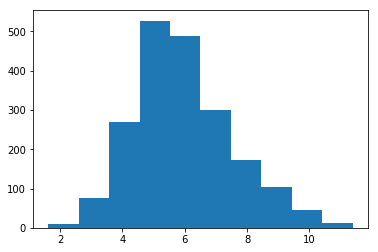

In [223]:
plt.hist(dist_nn)

In [224]:
np.percentile(dist_nn, 1)

2.8699873518943786

In [240]:
np.percentile(dist_nn, 5)

3.670094060897827

In [226]:
np.percentile(dist_nn, 10)

4.09266414642334

In [ ]:
with torch.no_grad():
    mask = r_separate_fast(rep_train.cpu(), torch.tensor(label), r=3.67)

38.94331073760986
39.675597190856934
39.61369252204895
39.625799894332886
44.339614391326904
46.05670785903931
39.857046365737915
40.022170543670654
39.80235147476196
39.6826593875885
39.84244227409363
39.954673290252686
39.96706247329712
39.54080319404602
39.737236738204956
48.70249009132385
38.920953035354614
39.29504704475403
39.11867713928223
39.11657762527466
39.10240197181702
39.29883813858032
39.24234414100647
38.97827863693237
38.94234848022461
41.548006772994995
46.75408148765564
39.23975324630737
38.72589588165283
38.84769916534424
38.53546857833862
38.72403287887573
38.38210344314575
38.78711223602295
38.60595941543579
38.604926109313965
43.95396041870117
43.6547212600708
38.78335785865784
38.86791276931763
38.842610120773315
38.72164702415466
38.708391427993774
38.77802348136902
38.740493059158325
38.58477783203125
38.54189729690552
47.37431812286377
39.557507038116455
37.582038164138794
37.49051094055176
37.835721015930176
37.56624221801758
37.76661467552185
37.49875164031

In [246]:
mask.sum()

tensor(52148)

In [243]:
pickle.dump(mask, open('wang_mnist_adv2_5.p', 'wb')) # 3.67

In [238]:
pickle.dump(mask, open('wang_mnist_adv2_1.p', 'wb')) # 2.86

In [244]:
num = 1000
dist = np.zeros((num, mask.sum()))

for i in range(num):
    dist[i] = (rep_train[mask][i].unsqueeze(0) - rep_train[mask]).norm(2, 1).cpu().numpy()

In [245]:
for i in range(num):
    if ((dist[i] < 2.8699) & (y_train[mask][i] != y_train[mask]).numpy()).sum() > 1:
        print('yikes')

In [193]:
# dknn = DKNNL2(net, x_train[mask], y_train[mask], x_valid, y_valid, layers, 
#               k=75, num_classes=10)
dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, num_classes=10)

In [194]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.9726


In [195]:
attack = DKNNL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layers[0], m=100, binary_search_steps=10,
            max_iterations=1000, learning_rate=1e-1, guide=1,
            initial_const=1e-1, abort_early=True, random_start=False)
    return x_adv

num = 2000
x_adv = attack_batch(x_test[ind][:num].cuda(), y_test[ind][:num], 100)

    step: 0; loss: 641.166; l2dist: 0.000
    step: 100; loss: 295.548; l2dist: 5.713
    step: 200; loss: 274.878; l2dist: 5.247
    step: 300; loss: 268.283; l2dist: 4.967
    step: 400; loss: 265.729; l2dist: 4.838
    step: 500; loss: 264.423; l2dist: 4.783
    step: 600; loss: 263.743; l2dist: 4.754
    step: 700; loss: 263.398; l2dist: 4.736
    step: 800; loss: 263.211; l2dist: 4.728
    step: 900; loss: 263.073; l2dist: 4.722
tensor(96., device='cuda:0')
binary step: 0; number of successful adv: 96/100
    step: 0; loss: 593.560; l2dist: 0.000
    step: 100; loss: 304.823; l2dist: 5.070
    step: 200; loss: 287.047; l2dist: 4.677
    step: 300; loss: 282.386; l2dist: 4.522
    step: 400; loss: 280.594; l2dist: 4.462
    step: 500; loss: 279.721; l2dist: 4.439
    step: 600; loss: 279.236; l2dist: 4.424
    step: 700; loss: 278.908; l2dist: 4.416
    step: 800; loss: 278.729; l2dist: 4.410
    step: 900; loss: 278.599; l2dist: 4.406
tensor(94., device='cuda:0')
binary step: 1; n

    step: 400; loss: 49.696; l2dist: 2.884
    step: 500; loss: 49.592; l2dist: 2.887
    step: 600; loss: 49.563; l2dist: 2.888
    step: 700; loss: 49.554; l2dist: 2.886
    step: 800; loss: 49.551; l2dist: 2.887
tensor(49., device='cuda:0')
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 82.409; l2dist: 0.000
    step: 100; loss: 55.058; l2dist: 2.799
    step: 200; loss: 51.258; l2dist: 2.908
    step: 300; loss: 50.024; l2dist: 2.911
    step: 400; loss: 49.725; l2dist: 2.901
    step: 500; loss: 49.611; l2dist: 2.901
    step: 600; loss: 49.578; l2dist: 2.901
    step: 700; loss: 49.563; l2dist: 2.901
    step: 800; loss: 49.555; l2dist: 2.901
    step: 900; loss: 49.553; l2dist: 2.900
tensor(56., device='cuda:0')
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 81.991; l2dist: 0.000
    step: 100; loss: 54.836; l2dist: 2.791
    step: 200; loss: 51.042; l2dist: 2.904
    step: 300; loss: 49.860; l2dist: 2.897
    step: 400; loss: 49.526; 

tensor(89., device='cuda:0')
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 116.596; l2dist: 0.000
    step: 100; loss: 72.867; l2dist: 3.471
    step: 200; loss: 66.506; l2dist: 3.488
    step: 300; loss: 64.908; l2dist: 3.460
    step: 400; loss: 64.284; l2dist: 3.439
    step: 500; loss: 64.142; l2dist: 3.431
    step: 600; loss: 64.024; l2dist: 3.426
    step: 700; loss: 63.979; l2dist: 3.423
    step: 800; loss: 63.953; l2dist: 3.424
    step: 900; loss: 63.925; l2dist: 3.424
tensor(83., device='cuda:0')
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 83.814; l2dist: 0.000
    step: 100; loss: 55.295; l2dist: 2.812
    step: 200; loss: 51.160; l2dist: 2.912
    step: 300; loss: 50.151; l2dist: 2.900
    step: 400; loss: 49.847; l2dist: 2.899
    step: 500; loss: 49.750; l2dist: 2.899
    step: 600; loss: 49.681; l2dist: 2.899
    step: 700; loss: 49.621; l2dist: 2.903
    step: 800; loss: 49.607; l2dist: 2.902
    step: 900; loss: 49.595;

    step: 300; loss: 46.815; l2dist: 2.761
    step: 400; loss: 46.559; l2dist: 2.752
    step: 500; loss: 46.452; l2dist: 2.751
    step: 600; loss: 46.429; l2dist: 2.750
    step: 700; loss: 46.419; l2dist: 2.752
    step: 800; loss: 46.403; l2dist: 2.752
    step: 900; loss: 46.401; l2dist: 2.753
tensor(95., device='cuda:0')
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 650.572; l2dist: 0.000
    step: 100; loss: 296.938; l2dist: 5.722
    step: 200; loss: 277.100; l2dist: 5.251
    step: 300; loss: 271.030; l2dist: 5.005
    step: 400; loss: 268.582; l2dist: 4.894
    step: 500; loss: 267.481; l2dist: 4.839
    step: 600; loss: 266.866; l2dist: 4.810
    step: 700; loss: 266.548; l2dist: 4.795
    step: 800; loss: 266.275; l2dist: 4.784
    step: 900; loss: 266.113; l2dist: 4.779
tensor(99., device='cuda:0')
binary step: 0; number of successful adv: 99/100
    step: 0; loss: 345.920; l2dist: 0.000
    step: 100; loss: 177.684; l2dist: 4.964
    step: 200; los

    step: 600; loss: 823612.125; l2dist: 2.836
    step: 700; loss: 822661.562; l2dist: 2.834
    step: 800; loss: 821948.250; l2dist: 2.837
    step: 900; loss: 821227.250; l2dist: 2.838
tensor(29., device='cuda:0')
binary step: 5; number of successful adv: 98/100
    step: 0; loss: 17252164.000; l2dist: 0.000
    step: 100; loss: 8739801.000; l2dist: 2.891
    step: 200; loss: 8423041.000; l2dist: 2.992
    step: 300; loss: 8331834.500; l2dist: 2.986
    step: 400; loss: 8286810.500; l2dist: 2.980
    step: 500; loss: 8266011.500; l2dist: 2.979
    step: 600; loss: 8250584.000; l2dist: 2.981
    step: 700; loss: 8240192.000; l2dist: 2.980
    step: 800; loss: 8235598.000; l2dist: 2.980
    step: 900; loss: 8230517.500; l2dist: 2.981
tensor(50., device='cuda:0')
binary step: 6; number of successful adv: 98/100
    step: 0; loss: 172520912.000; l2dist: 0.000
    step: 100; loss: 87366000.000; l2dist: 2.904
    step: 200; loss: 84295808.000; l2dist: 2.999
    step: 300; loss: 83317776.0

    step: 100; loss: 353.183; l2dist: 4.241
    step: 200; loss: 339.983; l2dist: 4.062
    step: 300; loss: 336.573; l2dist: 3.978
    step: 400; loss: 335.020; l2dist: 3.946
    step: 500; loss: 334.278; l2dist: 3.935
    step: 600; loss: 333.720; l2dist: 3.932
    step: 700; loss: 333.297; l2dist: 3.932
    step: 800; loss: 333.148; l2dist: 3.928
    step: 900; loss: 333.022; l2dist: 3.926
tensor(93., device='cuda:0')
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 424.933; l2dist: 0.000
    step: 100; loss: 206.845; l2dist: 3.422
    step: 200; loss: 198.605; l2dist: 3.484
    step: 300; loss: 196.227; l2dist: 3.440
    step: 400; loss: 195.288; l2dist: 3.428
    step: 500; loss: 194.907; l2dist: 3.425
    step: 600; loss: 194.671; l2dist: 3.421
    step: 700; loss: 194.494; l2dist: 3.421
    step: 800; loss: 194.345; l2dist: 3.419
    step: 900; loss: 194.270; l2dist: 3.417
tensor(81., device='cuda:0')
binary step: 3; number of successful adv: 100/100
    step

    step: 400; loss: 48.536; l2dist: 2.593
    step: 500; loss: 48.431; l2dist: 2.590
    step: 600; loss: 48.401; l2dist: 2.590
    step: 700; loss: 48.386; l2dist: 2.589
    step: 800; loss: 48.382; l2dist: 2.590
tensor(50., device='cuda:0')
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 79.472; l2dist: 0.000
    step: 100; loss: 54.233; l2dist: 2.534
    step: 200; loss: 50.533; l2dist: 2.637
    step: 300; loss: 49.444; l2dist: 2.654
    step: 400; loss: 49.048; l2dist: 2.653
    step: 500; loss: 48.919; l2dist: 2.650
    step: 600; loss: 48.884; l2dist: 2.650
    step: 700; loss: 48.866; l2dist: 2.649
    step: 800; loss: 48.861; l2dist: 2.650
    step: 900; loss: 48.860; l2dist: 2.649
tensor(90., device='cuda:0')
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 616.550; l2dist: 0.000
    step: 100; loss: 288.050; l2dist: 5.687
    step: 200; loss: 268.897; l2dist: 5.162
    step: 300; loss: 263.340; l2dist: 4.899
    step: 400; loss: 261.

    step: 800; loss: 40.974; l2dist: 2.774
tensor(63., device='cuda:0')
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 60.897; l2dist: 0.000
    step: 100; loss: 42.881; l2dist: 2.429
    step: 200; loss: 39.548; l2dist: 2.495
    step: 300; loss: 38.720; l2dist: 2.497
    step: 400; loss: 38.487; l2dist: 2.499
    step: 500; loss: 38.430; l2dist: 2.496
    step: 600; loss: 38.404; l2dist: 2.496
    step: 700; loss: 38.393; l2dist: 2.496
    step: 800; loss: 38.386; l2dist: 2.497
    step: 900; loss: 38.383; l2dist: 2.498
tensor(37., device='cuda:0')
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 64.044; l2dist: 0.000
    step: 100; loss: 44.984; l2dist: 2.586
    step: 200; loss: 41.341; l2dist: 2.697
    step: 300; loss: 40.285; l2dist: 2.686
    step: 400; loss: 40.029; l2dist: 2.684
    step: 500; loss: 39.982; l2dist: 2.680
    step: 600; loss: 39.958; l2dist: 2.680
    step: 700; loss: 39.946; l2dist: 2.681
    step: 800; loss: 39.941; 

    step: 300; loss: 153.464; l2dist: 4.329
    step: 400; loss: 152.769; l2dist: 4.297
    step: 500; loss: 152.510; l2dist: 4.284
    step: 600; loss: 152.387; l2dist: 4.281
    step: 700; loss: 152.316; l2dist: 4.278
    step: 800; loss: 152.298; l2dist: 4.278
    step: 900; loss: 152.287; l2dist: 4.278
tensor(97., device='cuda:0')
binary step: 1; number of successful adv: 99/100
    step: 0; loss: 423.474; l2dist: 0.000
    step: 100; loss: 243.553; l2dist: 4.062
    step: 200; loss: 232.579; l2dist: 3.918
    step: 300; loss: 230.177; l2dist: 3.856
    step: 400; loss: 229.186; l2dist: 3.845
    step: 500; loss: 228.943; l2dist: 3.842
    step: 600; loss: 228.853; l2dist: 3.841
    step: 700; loss: 228.784; l2dist: 3.840
    step: 800; loss: 228.761; l2dist: 3.839
    step: 900; loss: 228.726; l2dist: 3.839
tensor(89., device='cuda:0')
binary step: 2; number of successful adv: 99/100
    step: 0; loss: 2743.479; l2dist: 0.000
    step: 100; loss: 1608.587; l2dist: 3.354
    step: 

    step: 600; loss: 204.322; l2dist: 2.629
    step: 700; loss: 204.146; l2dist: 2.629
    step: 800; loss: 204.008; l2dist: 2.630
    step: 900; loss: 203.941; l2dist: 2.629
tensor(49., device='cuda:0')
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 372.584; l2dist: 0.000
    step: 100; loss: 213.413; l2dist: 2.450
    step: 200; loss: 205.615; l2dist: 2.602
    step: 300; loss: 203.426; l2dist: 2.614
    step: 400; loss: 202.635; l2dist: 2.611
    step: 500; loss: 202.218; l2dist: 2.615
    step: 600; loss: 202.020; l2dist: 2.615
    step: 700; loss: 201.857; l2dist: 2.617
    step: 800; loss: 201.743; l2dist: 2.615
    step: 900; loss: 201.683; l2dist: 2.616
tensor(46., device='cuda:0')
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 373.927; l2dist: 0.000
    step: 100; loss: 214.272; l2dist: 2.503
    step: 200; loss: 206.367; l2dist: 2.658
    step: 300; loss: 203.972; l2dist: 2.695
    step: 400; loss: 203.164; l2dist: 2.689
    step: 

    step: 800; loss: 52.398; l2dist: 3.287
    step: 900; loss: 52.394; l2dist: 3.285
tensor(81., device='cuda:0')
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 68.072; l2dist: 0.000
    step: 100; loss: 47.462; l2dist: 2.737
    step: 200; loss: 43.603; l2dist: 2.881
    step: 300; loss: 42.385; l2dist: 2.864
    step: 400; loss: 42.018; l2dist: 2.862
    step: 500; loss: 41.909; l2dist: 2.856
    step: 600; loss: 41.879; l2dist: 2.856
    step: 700; loss: 41.838; l2dist: 2.859
    step: 800; loss: 41.830; l2dist: 2.859
    step: 900; loss: 41.828; l2dist: 2.860
tensor(56., device='cuda:0')
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 65.304; l2dist: 0.000
    step: 100; loss: 45.463; l2dist: 2.551
    step: 200; loss: 41.986; l2dist: 2.668
    step: 300; loss: 40.865; l2dist: 2.677
    step: 400; loss: 40.465; l2dist: 2.669
    step: 500; loss: 40.375; l2dist: 2.666
    step: 600; loss: 40.352; l2dist: 2.665
    step: 700; loss: 40.338; 

    step: 400; loss: 264.504; l2dist: 4.730
    step: 500; loss: 263.520; l2dist: 4.677
    step: 600; loss: 263.116; l2dist: 4.660
    step: 700; loss: 262.952; l2dist: 4.653
    step: 800; loss: 262.803; l2dist: 4.645
    step: 900; loss: 262.736; l2dist: 4.642
tensor(96., device='cuda:0')
binary step: 0; number of successful adv: 96/100
    step: 0; loss: 443.689; l2dist: 0.000
    step: 100; loss: 225.628; l2dist: 4.969
    step: 200; loss: 211.137; l2dist: 4.543
    step: 300; loss: 207.509; l2dist: 4.391
    step: 400; loss: 206.375; l2dist: 4.345
    step: 500; loss: 205.838; l2dist: 4.327
    step: 600; loss: 205.618; l2dist: 4.320
    step: 700; loss: 205.475; l2dist: 4.314
    step: 800; loss: 205.408; l2dist: 4.314
    step: 900; loss: 205.381; l2dist: 4.313
tensor(95., device='cuda:0')
binary step: 1; number of successful adv: 97/100
    step: 0; loss: 1234.029; l2dist: 0.000
    step: 100; loss: 644.679; l2dist: 4.182
    step: 200; loss: 625.312; l2dist: 4.024
    step: 3

binary step: 6; number of successful adv: 100/100
    step: 0; loss: 66.925; l2dist: 0.000
    step: 100; loss: 47.422; l2dist: 2.487
    step: 200; loss: 44.088; l2dist: 2.627
    step: 300; loss: 43.174; l2dist: 2.637
    step: 400; loss: 42.967; l2dist: 2.637
    step: 500; loss: 42.869; l2dist: 2.643
    step: 600; loss: 42.821; l2dist: 2.645
    step: 700; loss: 42.808; l2dist: 2.645
    step: 800; loss: 42.799; l2dist: 2.645
    step: 900; loss: 42.792; l2dist: 2.644
tensor(45., device='cuda:0')
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 67.192; l2dist: 0.000
    step: 100; loss: 47.607; l2dist: 2.489
    step: 200; loss: 44.199; l2dist: 2.629
    step: 300; loss: 43.347; l2dist: 2.640
    step: 400; loss: 43.129; l2dist: 2.642
    step: 500; loss: 43.082; l2dist: 2.641
    step: 600; loss: 43.069; l2dist: 2.641
    step: 700; loss: 43.064; l2dist: 2.640
    step: 800; loss: 43.063; l2dist: 2.642
tensor(46., device='cuda:0')
binary step: 8; number of suc

In [196]:
(x_adv.detach().cpu() - x_test[ind][:num]).view(x_adv.size(0), -1).norm(2, 1).mean()

tensor(2.7761)

In [247]:
dknn = DKNNL2(net, x_train[mask], y_train[mask], x_valid, y_valid, layers, 
              k=75, num_classes=10)

In [248]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.9715


In [249]:
attack = DKNNL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layers[0], m=100, binary_search_steps=10,
            max_iterations=1000, learning_rate=1e-1, guide=1,
            initial_const=1e-3, abort_early=True, random_start=False)
    return x_adv

num = 100
x_adv = attack_batch(x_test[ind][:num].cuda(), y_test[ind][:num], 100)

    step: 0; loss: 6.680; l2dist: 0.000
    step: 100; loss: 6.423; l2dist: 0.463
    step: 200; loss: 6.421; l2dist: 0.465
    step: 300; loss: 6.416; l2dist: 0.470
    step: 400; loss: 6.410; l2dist: 0.477
    step: 500; loss: 6.408; l2dist: 0.480
    step: 600; loss: 6.406; l2dist: 0.481
    step: 700; loss: 6.406; l2dist: 0.481
    step: 800; loss: 6.405; l2dist: 0.482
tensor(3., device='cuda:0')
binary step: 0; number of successful adv: 3/100
    step: 0; loss: 65.175; l2dist: 0.000
    step: 100; loss: 46.695; l2dist: 2.797
    step: 200; loss: 42.105; l2dist: 3.014
    step: 300; loss: 40.821; l2dist: 2.992
    step: 400; loss: 40.496; l2dist: 2.981
    step: 500; loss: 40.407; l2dist: 2.985
    step: 600; loss: 40.378; l2dist: 2.984
    step: 700; loss: 40.373; l2dist: 2.983
    step: 800; loss: 40.366; l2dist: 2.983
    step: 900; loss: 40.365; l2dist: 2.983
tensor(65., device='cuda:0')
binary step: 1; number of successful adv: 67/100
    step: 0; loss: 224.355; l2dist: 0.000


In [239]:
(x_adv.detach().cpu() - x_test[ind][:num]).view(x_adv.size(0), -1).norm(2, 1).mean()

tensor(2.7596)